# Earth - Topography grid at 10 arc-minute resolution

Global 10 arc-minute resolution grids of topography (ETOPO1 ice-surface) referenced to mean sea-level (which we will consider to be the geoid). 

**Source:** [ETOPO1](https://doi.org/10.7289/V5C8276M) (grid generated by the [ICGEM calculation service](http://icgem.gfz-potsdam.de/home))

**License:** [public domain](https://ngdc.noaa.gov/mgg/global/dem_faq.html#sec-2.4)

## Notes

This notebook loads the grid from the text file, sets proper CF-compliant metadata, and saves it to compressed netCDF for a smaller file size (requires the netcdf4 library for loading). Coordinates are referenced to WGS84.

In [1]:
import os
import lzma
from pathlib import Path
import xarray as xr
import numpy as np
import harmonica as hm
import pygmt
import pooch

## Read the data

Use Harmonica to read the data.

In [2]:
with lzma.open(Path("raw") / "etopo1.gdf.xz", "rt") as f:
    data_raw = hm.load_icgem_gdf(f, dtype="float32")
icgem_metadata = data_raw.attrs.copy()
data = data_raw.topography_shm.rename("topography")
data

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2741.967 ,  2741.967 ,  2741.967 , ...,  2741.967 ,  2741.967 ,
         2741.967 ],
       [ 2768.2942,  2768.1946,  2768.095 , ...,  2768.493 ,  2768.3936,
         2768.2942],
       [ 2821.9172,  2821.685 ,  2821.4526, ...,  2822.3804,  2822.149 ,
         2821.9172],
       ...,
       [-4243.443 , -4244.1055, -4244.761 , ..., -4242.097 , -4242.7734,
        -4243.443 ],
       [-4156.4565, -4156.5615, -4156.666 , ..., -4156.246 , -4156.3516,
        -4156.4565],
       [-4236.9985, -4236.9985, -4236.9985, ..., -4236.9985, -4236.9985,
        -4236.9985]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float32 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0

## Fix grid coordinates

Coordinates are slightly imprecise since ICGEM uses something like `np.arange` to generate them instead of `np.linspace`, which is more precise and the correct way to do it. This means that the spacing is not exactly constant, which can mess up plotting with PyGMT later on. Fix this by assigning adjusted coordinates. This shouldn't make a difference quantitatively since changes are in the order of 1e-5 or below.

In [3]:
def fix_coordinates(grid):
    """
    Replace coordinates with ones generated with np.linspace.
    """
    longitude = np.linspace(-180, 180, grid.longitude.size)
    latitude = np.linspace(-90, 90, grid.latitude.size)
    return grid.assign_coords(longitude=longitude, latitude=latitude)

In [4]:
data = fix_coordinates(data)
data

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2741.967 ,  2741.967 ,  2741.967 , ...,  2741.967 ,  2741.967 ,
         2741.967 ],
       [ 2768.2942,  2768.1946,  2768.095 , ...,  2768.493 ,  2768.3936,
         2768.2942],
       [ 2821.9172,  2821.685 ,  2821.4526, ...,  2822.3804,  2822.149 ,
         2821.9172],
       ...,
       [-4243.443 , -4244.1055, -4244.761 , ..., -4242.097 , -4242.7734,
        -4243.443 ],
       [-4156.4565, -4156.5615, -4156.666 , ..., -4156.246 , -4156.3516,
        -4156.4565],
       [-4236.9985, -4236.9985, -4236.9985, ..., -4236.9985, -4236.9985,
        -4236.9985]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0

## Set proper metadata

Add proper metadata following CF-conventions to all `DataArrays` and the `Dataset` as a whole.

In [5]:
def minmax_round(grid, decimals):
    """
    Return the minimum and maximum values in the grid 
    rounded to *decimal* places.
    """
    vmin = np.round(grid.values.min(), decimals=decimals)
    vmax = np.round(grid.values.max(), decimals=decimals)
    return (vmin, vmax)

In [6]:
data.attrs = {
    "Conventions": "CF-1.8",
    "title": "Topographic and bathymetric height of ETOPO1 (ice surface) at 10 arc-minute resolution",
    "crs": "WGS84",
    "source": "Generated from a spherical harmonic model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "public domain",
    "references": "https://doi.org/10.7289/V5C8276M",
    "long_name": "topographic height above mean sea level",
    "standard_name": "height_above_mean_sea_level",
    "description": "height topography/bathymetry referenced to mean sea level",
    "units": "m",
    "actual_range": minmax_round(data, decimals=0),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in icgem_metadata.items()]),
}
data.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (data.longitude.values.min(), data.longitude.values.max()),
}
data.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (data.latitude.values.min(), data.latitude.values.max()),
}
data

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2741.967 ,  2741.967 ,  2741.967 , ...,  2741.967 ,  2741.967 ,
         2741.967 ],
       [ 2768.2942,  2768.1946,  2768.095 , ...,  2768.493 ,  2768.3936,
         2768.2942],
       [ 2821.9172,  2821.685 ,  2821.4526, ...,  2822.3804,  2822.149 ,
         2821.9172],
       ...,
       [-4243.443 , -4244.1055, -4244.761 , ..., -4242.097 , -4242.7734,
        -4243.443 ],
       [-4156.4565, -4156.5615, -4156.666 , ..., -4156.246 , -4156.3516,
        -4156.4565],
       [-4236.9985, -4236.9985, -4236.9985, ..., -4236.9985, -4236.9985,
        -4236.9985]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    (-10023.0, 6082.0)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


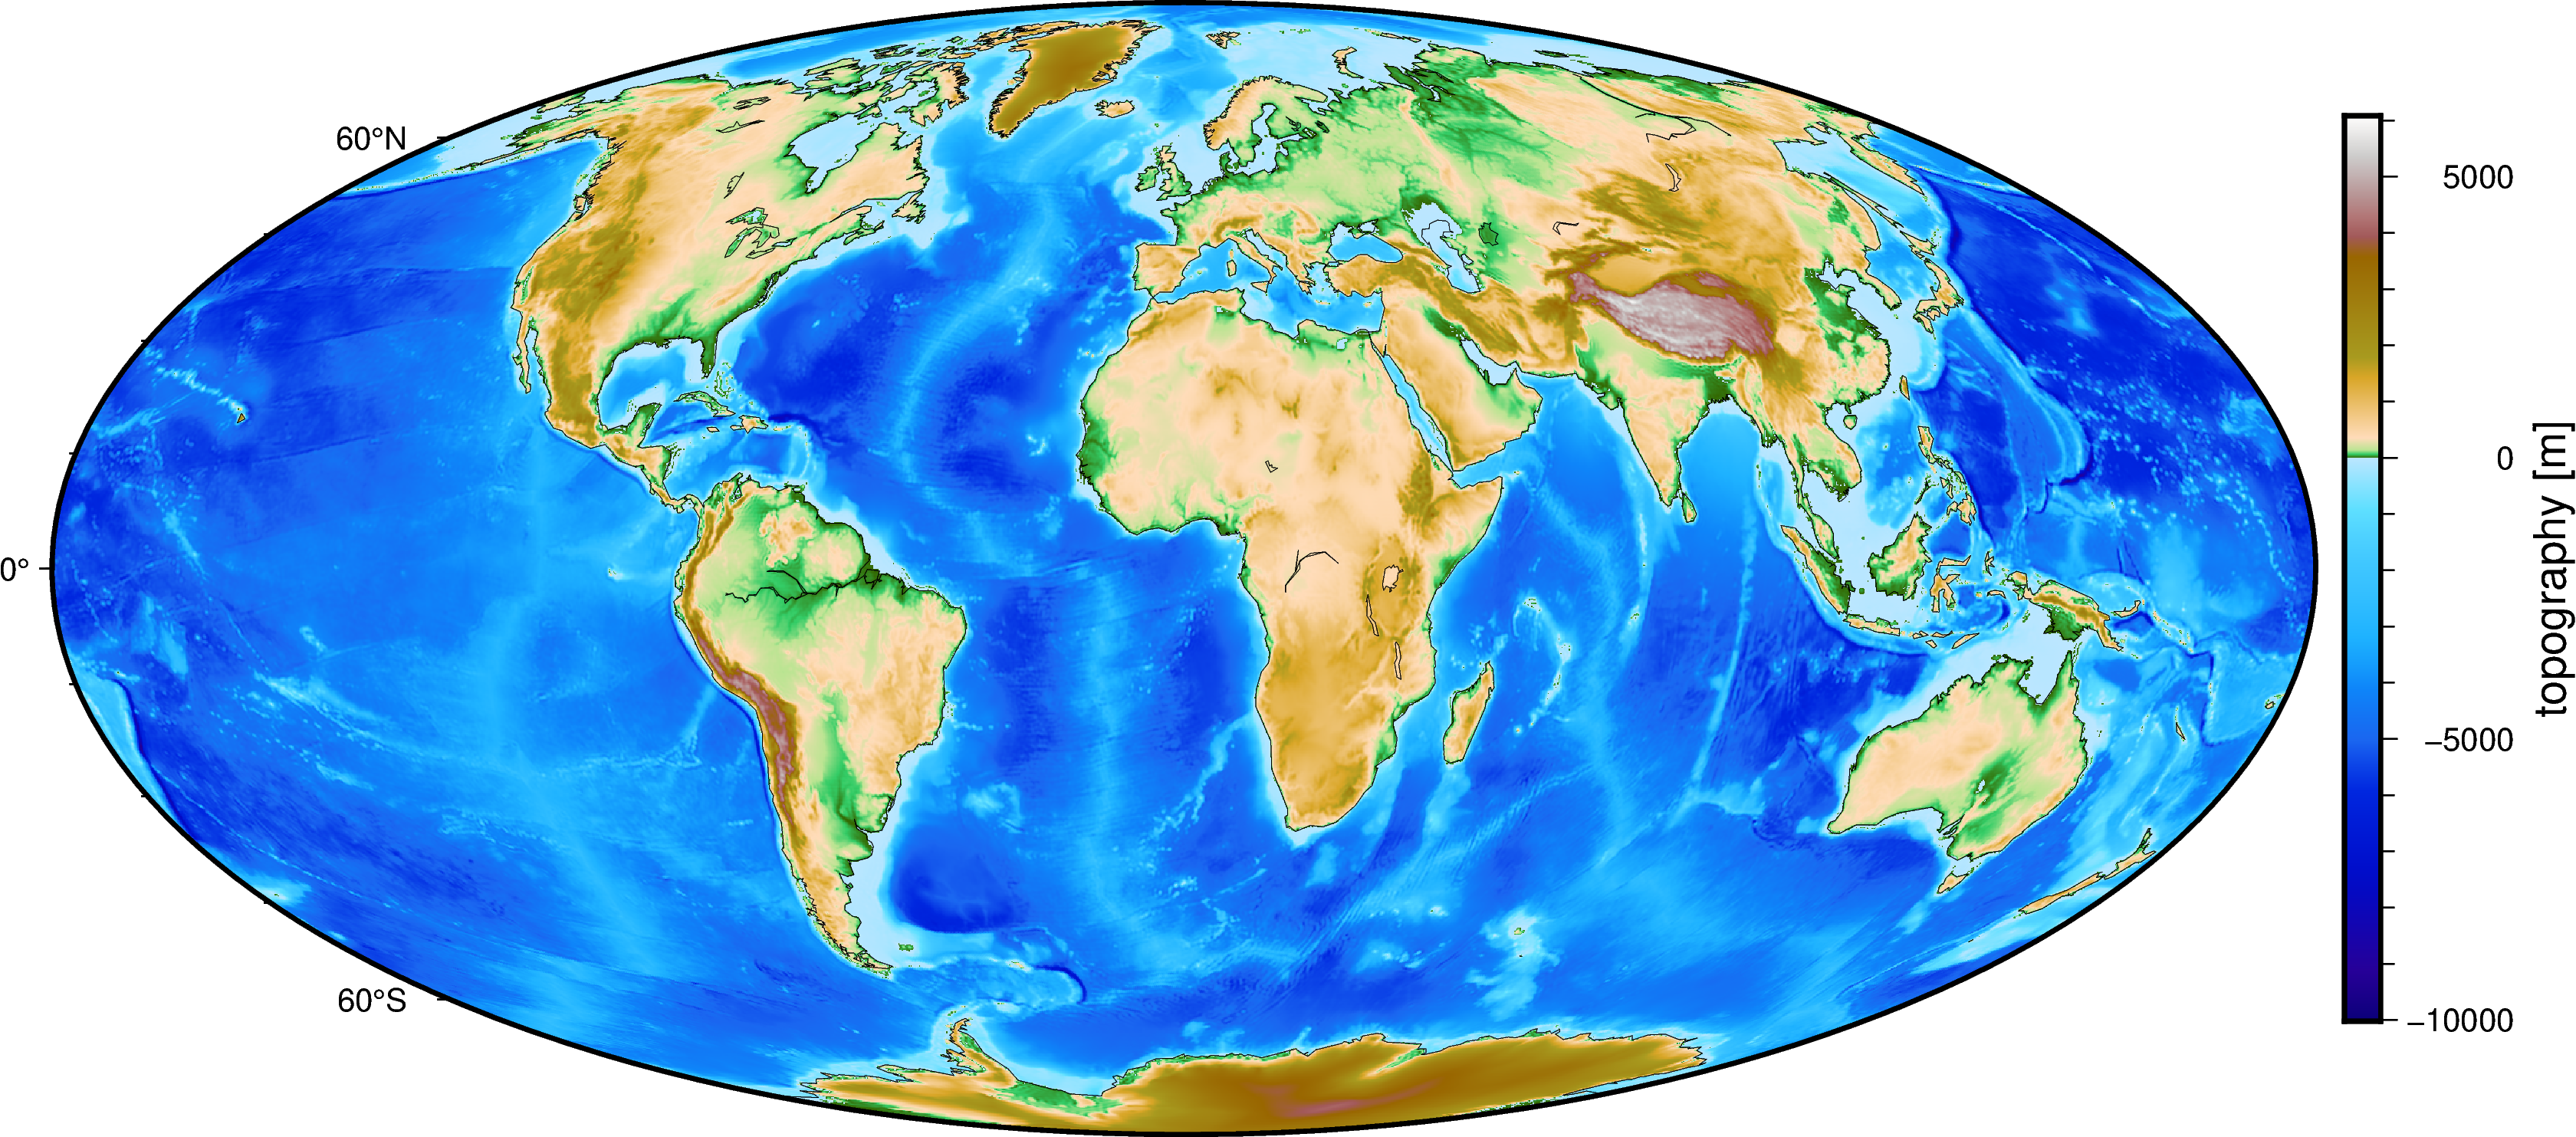

In [7]:
fig = pygmt.Figure()
fig.grdimage(data, cmap="etopo1", projection="W25c")
fig.colorbar(frame='af+l"topography [m]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p", area_thresh=1e4)
fig.savefig("preview.jpg", dpi=200)
fig.show()

## Export

Save the grid to a netCDF file and calculate the size and MD5/SHA256 hashes. 

Use compression (both zlib and discretization based) to reduce the file sizes. The `scale_factor` determines the amount of decimal places retained when converting floats into integers. See http://xarray.pydata.org/en/stable/user-guide/io.html#writing-encoded-data

In [8]:
output = "earth-topography-10arcmin.nc"
data.to_netcdf(
    output, 
    format="NETCDF4",
    encoding={
        'topography': {
            "zlib": True, 
            'dtype': 'int16', 
            'scale_factor': 1.0, 
            '_FillValue': 32000, 
            'add_offset': 0,
        },
    }
)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: earth-topography-10arcmin.nc
size: 2.746982 Mb
md5:c43b61322e03669c4313ba3d9a58028d
sha256:e45628a3f559ec600a4003587a2b575402d22986651ee48806930aa909af4cf6


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [9]:
data_reloaded = xr.load_dataarray(output)
data_reloaded

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

Make the figure again but don't save it to a file this time.

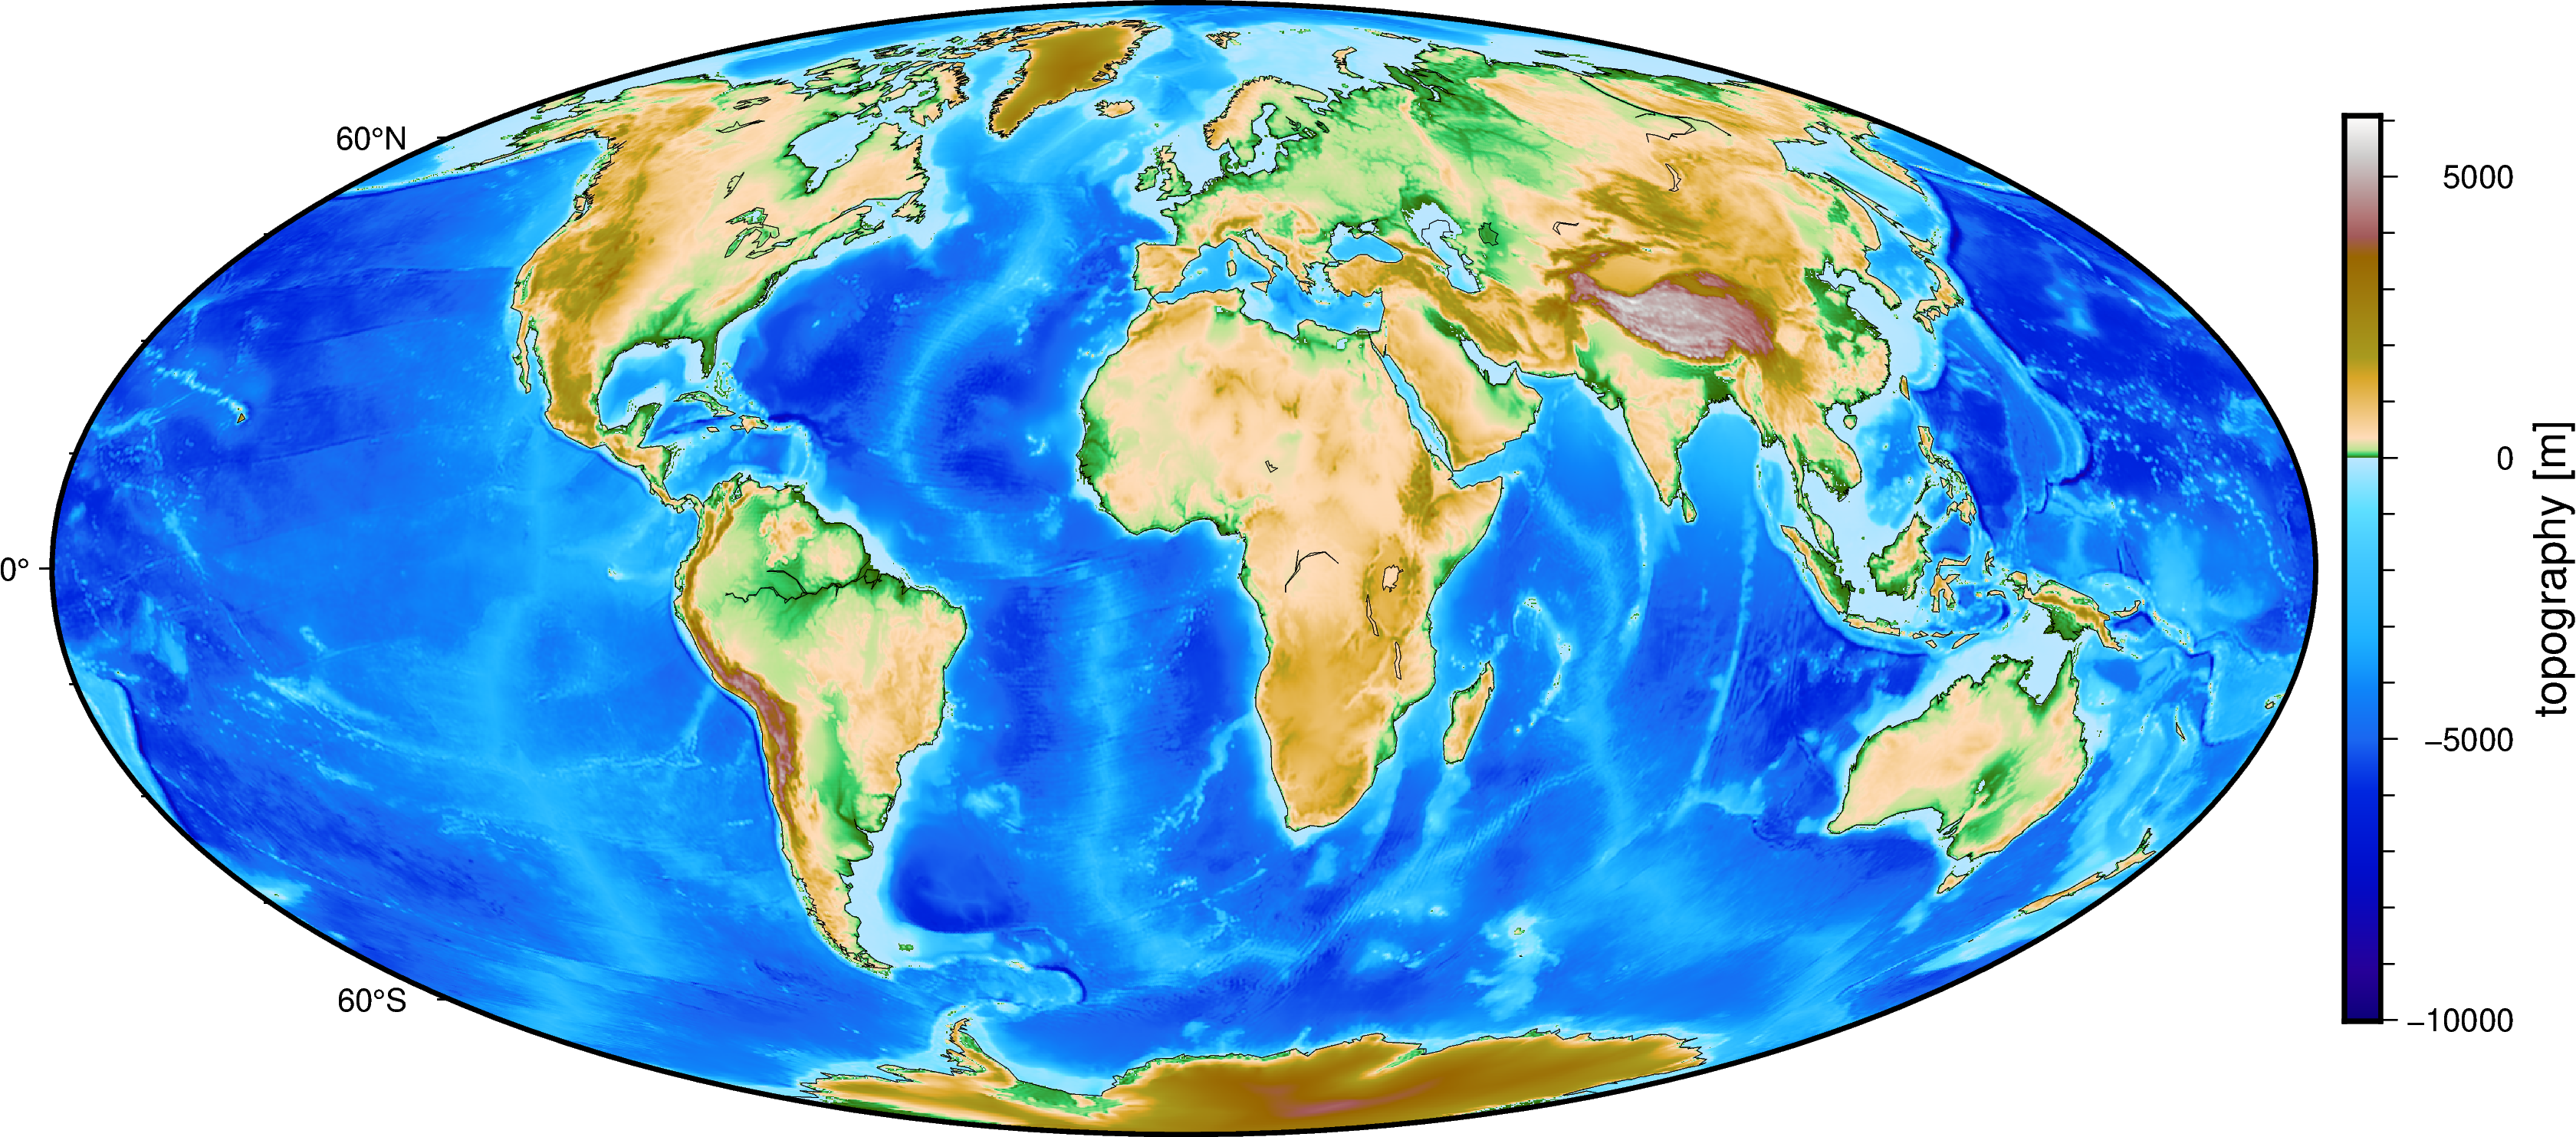

In [10]:
fig = pygmt.Figure()
fig.grdimage(data_reloaded, cmap="etopo1", projection="W25c")
fig.colorbar(frame='af+l"topography [m]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p", area_thresh=1e4)
fig.show()